In [1]:
from scipy.stats import nbinom
import math
import numpy as np
import matplotlib.pyplot as plt




In [2]:
# Monte Carlo to estimate R effective for each dispersion param
NUM_SIMS = 10000

COVID_RO = 2.4

MAX_GENERARATIONS = 30 

MAX_GATHERING_SIZE = 10

def draw_binomial(k, limit=MAX_GATHERING_SIZE):
    mean = COVID_RO
    variance = mean + (mean**2)/k
    p = mean/variance
    n = mean**2 / (variance - mean)
    draw = nbinom.rvs(n=n,p=p)
    if (draw > limit): # limit superspreaders
        draw = limit 
    return draw

def compute_re(k, limit):
    secondary_infection_list = []
    for _ in range(NUM_SIMS):
        secondary_infection_list.append(draw_binomial(k, limit))
    R_effective = sum(secondary_infection_list) / len(secondary_infection_list)

    return R_effective

ks = [0.04, 0.1,.5,1,2.97]
res = []

for k in ks:
    res.append(compute_re(k, MAX_GATHERING_SIZE))

In [3]:
import scipy.optimize as sp

def compute_epidemic_size(r0, should_plot=False):
    def f(r_inf):
        return r_inf

    def g(r_inf, r_naught):
        return 1 - np.exp(-r_naught * r_inf)

    def h(r_inf, r0):
        return f(r_inf) - g(r_inf, r_naught=r0)

    x = np.linspace(0, 1, 25)

    f_vals = f(x)
    g_vals = g(x, r0)

    rinf = sp.fsolve(h, 1, r0)

    if (should_plot == True):
        plt.plot(x, f_vals, c = 'k')
        plt.plot(x, g_vals, c = 'r')
        plt.scatter(rinf, rinf)
        plt.xlabel("Rinf")
        plt.ylabel("Rinf")
        plt.title(r0)
        plt.show()
    return rinf

In [4]:
for re in res:
    print(re)
    final_infected_proportion = compute_epidemic_size(re)  
    print("R-Effective: ",re, " Percent of population who will become infected at some point before the epidemic dies: ", final_infected_proportion * 100)

0.915
R-Effective:  0.915  Percent of population who will become infected at some point before the epidemic dies:  [5.55111512e-14]
1.4018
R-Effective:  1.4018  Percent of population who will become infected at some point before the epidemic dies:  [51.2434567]
2.1676
R-Effective:  2.1676  Percent of population who will become infected at some point before the epidemic dies:  [83.70695752]
2.3222
R-Effective:  2.3222  Percent of population who will become infected at some point before the epidemic dies:  [86.62156265]
2.4119
R-Effective:  2.4119  Percent of population who will become infected at some point before the epidemic dies:  [88.03721472]


In [5]:
def simulate(num_generations, k):
    num_drawn = draw_binomial(k)
    # prevent runaway condition
    if(num_generations > MAX_GENERARATIONS):
        return False

    # dies
    if (num_drawn == 0):
        return True
    
    # spawns new generations
    else:
        for _ in range(num_drawn):
            if not simulate(num_generations + 1, k):
                return False
        return True

In [6]:
# simulate many
ks = [0.1,.5,1,5,10]
k = 1
grows_large = 0
for i in range(NUM_SIMS):
    res = simulate(0, k) # start at 0 generations of infected
    if res == False: # grows large
        grows_large += 1

fraction_epidemic = grows_large/NUM_SIMS
print(fraction_epidemic * 100, "% of simulations will become endemic")

57.99999999999999 % of simulations will become endemic


In [7]:
# simulate r-effectives for different event size limits
def plot_res_limits(k):
    limits = [0,1,2,3,4,5,10,15,20,50,100,200]
    re_list = []
    for limit in limits:
        re_list.append(compute_re(k, limit))
    plt.plot(limits,re_list)
    plt.xlabel("max gathering size")
    plt.ylabel("R-effective")
    plt.title(f"k:{k}")
    plt.show()

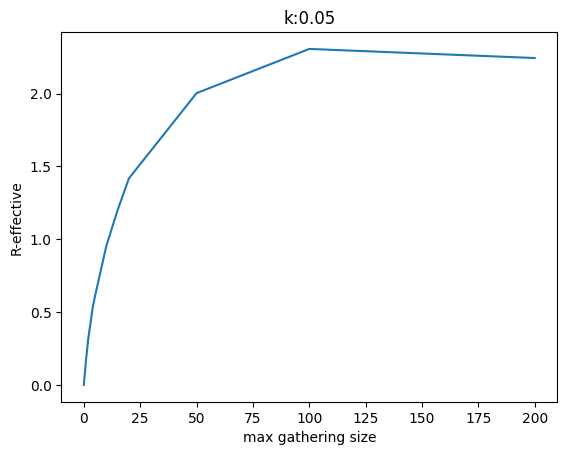

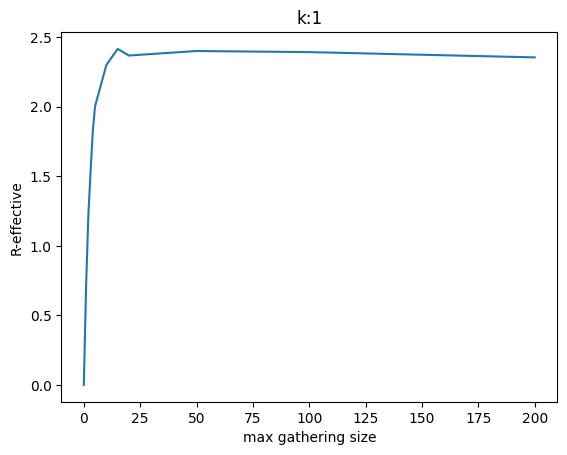

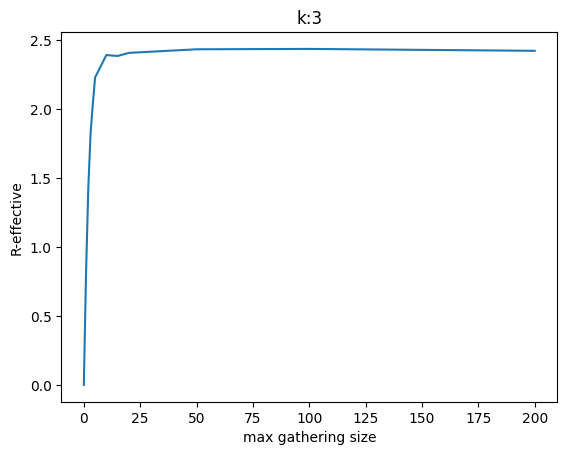

In [8]:
ks = [0.05,1,3]
for k in ks:
    plot_res_limits(k)